## Softmax Regression

In [2]:
import torch 
from torch.utils.data import DataLoader, random_split 
from torchvision import datasets, transforms 

- We'll compute the softmax using three steps:
1. Exponentiation of each term.
2. A sum over each row to compute the normalization constant for each example.
3. Division of each row by its normalization constant, ensuring that the result sums to 1.
- The denominator is called the (log) partition function.
  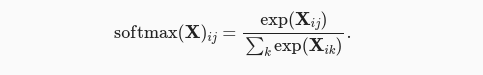

In [10]:
# The softmax function 
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdims=True)
    return X_exp / partition 

# The cross-entropy loss function 
def cross_entropy(y_hat, y):
    return -torch.log(y_hat[range(len(y_hat)), y]).mean()

# Softmax Regression Class 
class SoftmaxRegression:
    def __init__(self, num_inputs, num_outputs, lr, sigma=0.01):
        self.W = torch.normal(0, sigma, size=(num_inputs, num_outputs), requires_grad=True)
        self.b = torch.zeros(num_outputs, requires_grad=True)
        self.lr = lr

    def forward(self, X):
        X = X.reshape((-1, self.W.shape[0]))
        return softmax(torch.matmul(X, self.W) + self.b)

    def loss(self, y_hat, y):
        return cross_entropy(y_hat, y)

    def parameters(self):
        return [self.W, self.b]

    def step(self):
        with torch.no_grad():
            for param in self.parameters():
                param -= self.lr * param.grad
                param.grad.zero_()

In [11]:
# Preprocessing the FashionMNIST dataset 
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(0.5, 0.5)])
dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256)

In [12]:
# Initialize the model 
num_inputs = 784 
num_outputs = 10 
lr = 0.1 
model = SoftmaxRegression(num_inputs, num_outputs, lr)

In [13]:
# Training loop
max_epochs = 10
for epoch in range(max_epochs):
    for X, y in train_loader:
        X = X.view(-1, 28 * 28)  # Flatten the images
        y_hat = model.forward(X)
        loss = model.loss(y_hat, y)

        # Backpropagation
        loss.backward()
        model.step()

    # Validation loss
    with torch.no_grad():
        val_loss = 0
        correct = 0
        total = 0
        for X, y in val_loader:
            X = X.view(-1, 28 * 28)  # Flatten the images
            y_hat = model.forward(X)
            val_loss += model.loss(y_hat, y).item()
            preds = y_hat.argmax(axis=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
        val_loss /= len(val_loader)
        accuracy = correct / total
    print(f"Epoch {epoch + 1}/{max_epochs}, Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}")

Epoch 1/10, Validation Loss: 0.5471, Accuracy: 0.8091
Epoch 2/10, Validation Loss: 0.6457, Accuracy: 0.7509
Epoch 3/10, Validation Loss: 0.4730, Accuracy: 0.8374
Epoch 4/10, Validation Loss: 0.5307, Accuracy: 0.8180
Epoch 5/10, Validation Loss: 0.5128, Accuracy: 0.8054
Epoch 6/10, Validation Loss: 0.4754, Accuracy: 0.8313
Epoch 7/10, Validation Loss: 0.4486, Accuracy: 0.8393
Epoch 8/10, Validation Loss: 0.4659, Accuracy: 0.8367
Epoch 9/10, Validation Loss: 0.4402, Accuracy: 0.8407
Epoch 10/10, Validation Loss: 0.5358, Accuracy: 0.8143


- We are more interested in the images we label incorrectly.
- We visualize them by comparing their actual labels with the predictions from the model. 

In [14]:
import matplotlib.pyplot as plt 

In [15]:
X, y = next(iter(val_loader))
X = X.view(-1, 28 * 28)
y_hat = model.forward(X)
preds = y_hat.argmax(axis=1)

wrong_idx = preds != y
X_wrong, y_wrong, preds_wrong = X[wrong_idx], y[wrong_idx], preds[wrong_idx]

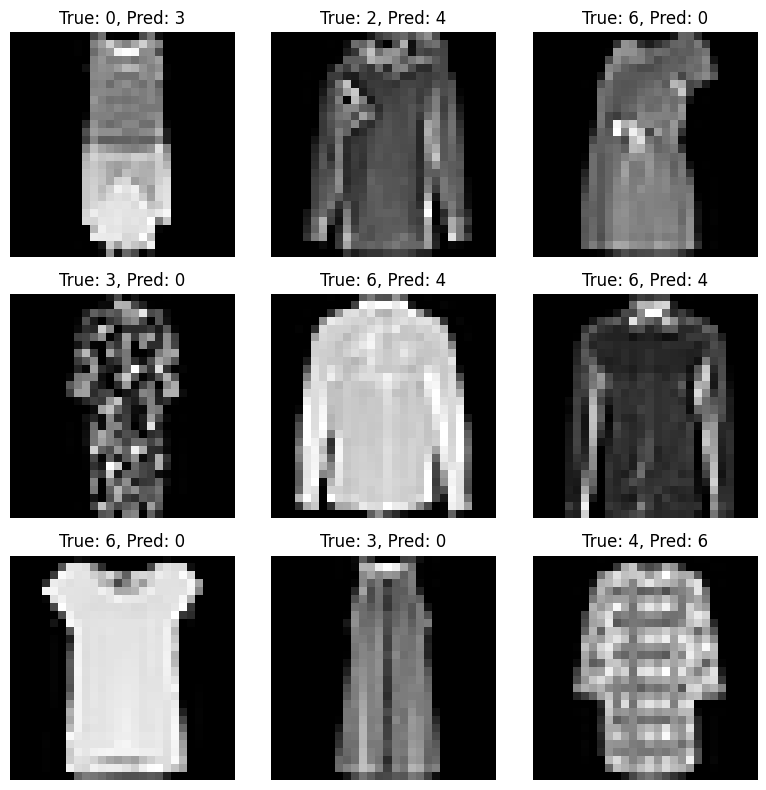

In [16]:
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
axes = axes.flatten()
for i, ax in enumerate(axes):
    if i < len(X_wrong):
        img = X_wrong[i].reshape(28, 28).detach().numpy()
        ax.imshow(img, cmap='gray')
        ax.set_title(f"True: {y_wrong[i].item()}, Pred: {preds_wrong[i].item()}")
        ax.axis('off')
plt.tight_layout()
plt.show()

- Reference[https://d2l.ai/chapter_linear-classification/index.html]